In [3]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load the games data
games = pd.read_csv('../games.csv')

# Load the teams data
teams = pd.read_csv('../teams.csv')

# Filter out the 2022 season
games = games[games['SEASON'] != 2022]
games = games.dropna()

# Convert GAME_DATE_EST to datetime
games['GAME_DATE_EST'] = pd.to_datetime(games['GAME_DATE_EST'])

# Split the data into training (up to 2020) and testing (2021 season)
train_games = games[(games['SEASON'] <= 2020) & (games['SEASON']>=2017)]
test_games = games[games['SEASON'] == 2021]

print("Training data shape:", train_games.shape)
print("Testing data shape:", test_games.shape)


Training data shape: (5250, 21)
Testing data shape: (1389, 21)


In [5]:
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
542,2022-06-16,42100406,Final,1610612738,1610612744,2021,1610612738,90.0,0.425,0.917,...,27.0,41.0,1610612744,103.0,0.413,1.000,0.413,27.0,44.0,0
543,2022-06-13,42100405,Final,1610612744,1610612738,2021,1610612744,104.0,0.466,0.867,...,23.0,39.0,1610612738,94.0,0.413,0.677,0.344,18.0,47.0,1
544,2022-06-10,42100404,Final,1610612738,1610612744,2021,1610612738,97.0,0.400,0.737,...,22.0,42.0,1610612744,107.0,0.440,0.800,0.349,20.0,55.0,0
545,2022-06-08,42100403,Final,1610612738,1610612744,2021,1610612738,116.0,0.483,0.708,...,28.0,47.0,1610612744,100.0,0.462,0.867,0.375,22.0,31.0,1
546,2022-06-05,42100402,Final,1610612744,1610612738,2021,1610612744,107.0,0.453,0.700,...,25.0,42.0,1610612738,88.0,0.375,0.765,0.405,24.0,43.0,1


In [6]:
# Combine the HOME_TEAM_ID and VISITOR_TEAM_ID into a single DataFrame
X_train = train_games[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']]
X_test = test_games[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit the encoder on the combined team IDs from training data
encoder.fit(X_train)

# Transform the team IDs
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

print("Encoded feature shape:", X_train_encoded.shape)


Encoded feature shape: (5250, 60)


In [7]:
# Target variables
y_train = train_games[['PTS_home', 'PTS_away']]
y_test = test_games[['PTS_home', 'PTS_away']]


In [8]:
# Initialize the model
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))

# Train the model
model.fit(X_train_encoded, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [9]:
# Make predictions on the test set
y_pred = model.predict(X_test_encoded)

# Add predictions to the test DataFrame
test_games = test_games.reset_index(drop=True)
test_games['PTS_home_pred'] = y_pred[:, 0]
test_games['PTS_away_pred'] = y_pred[:, 1]

# Determine predicted winners
test_games['HOME_TEAM_WINS_pred'] = np.where(
    test_games['PTS_home_pred'] > test_games['PTS_away_pred'], 1, 0)


In [10]:
# Create a mapping from TEAM_ID to team names
team_id_to_name = teams.set_index('TEAM_ID')['NICKNAME'].to_dict()

# Map team IDs to names in the test DataFrame
test_games['HOME_TEAM_NAME'] = test_games['HOME_TEAM_ID'].map(team_id_to_name)
test_games['VISITOR_TEAM_NAME'] = test_games['VISITOR_TEAM_ID'].map(team_id_to_name)


In [11]:
# Calculate MAE for score predictions
mae_home = mean_absolute_error(test_games['PTS_home'], test_games['PTS_home_pred'])
mae_away = mean_absolute_error(test_games['PTS_away'], test_games['PTS_away_pred'])

print(f"Mean Absolute Error for Home Team Points: {mae_home:.2f}")
print(f"Mean Absolute Error for Away Team Points: {mae_away:.2f}")

# Calculate accuracy for winner predictions
accuracy = accuracy_score(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
print(f"Accuracy for predicting winner: {accuracy * 100:.2f}%")


Mean Absolute Error for Home Team Points: 10.52
Mean Absolute Error for Away Team Points: 10.78
Accuracy for predicting winner: 51.48%


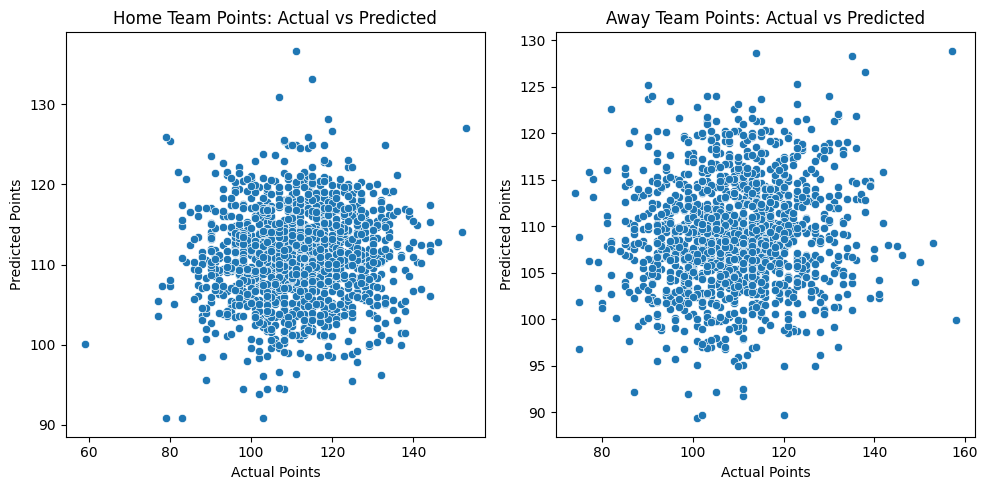

In [12]:
# Scatter plot for Home Team Points
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=test_games['PTS_home'], y=test_games['PTS_home_pred'])
plt.title('Home Team Points: Actual vs Predicted')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

# Scatter plot for Away Team Points
plt.subplot(1, 2, 2)
sns.scatterplot(x=test_games['PTS_away'], y=test_games['PTS_away_pred'])
plt.title('Away Team Points: Actual vs Predicted')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')

plt.tight_layout()
plt.show()


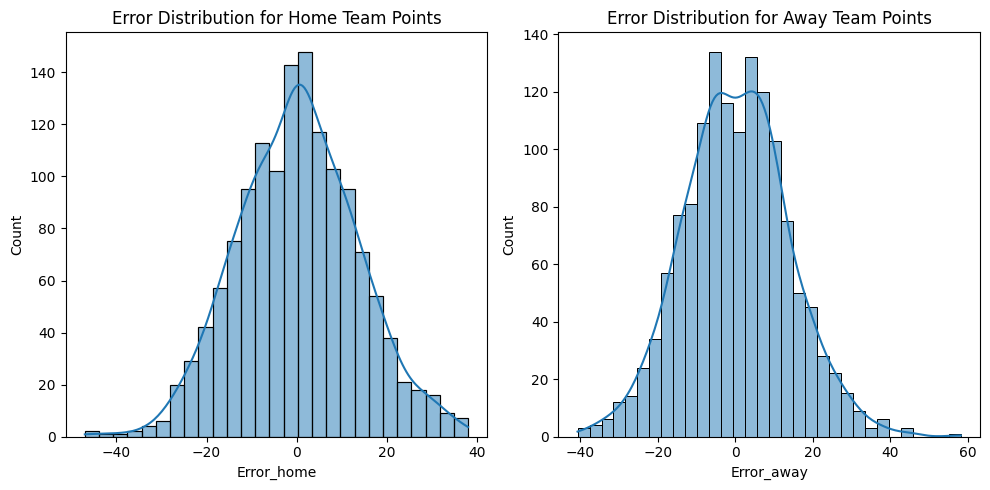

In [13]:
# Calculate errors
test_games['Error_home'] = test_games['PTS_home'] - test_games['PTS_home_pred']
test_games['Error_away'] = test_games['PTS_away'] - test_games['PTS_away_pred']

# Histogram of errors
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.histplot(test_games['Error_home'], kde=True)
plt.title('Error Distribution for Home Team Points')

plt.subplot(1, 2, 2)
sns.histplot(test_games['Error_away'], kde=True)
plt.title('Error Distribution for Away Team Points')

plt.tight_layout()
plt.show()


In [14]:
# Display the predicted scores and team names
output_columns = [
    'GAME_DATE_EST', 'HOME_TEAM_NAME', 'VISITOR_TEAM_NAME',
    'PTS_home_pred', 'PTS_away_pred', 'HOME_TEAM_WINS_pred'
]

predicted_results = test_games[output_columns]

# Round the predicted points
predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)

print(predicted_results.head(40))


   GAME_DATE_EST HOME_TEAM_NAME VISITOR_TEAM_NAME  PTS_home_pred  \
0     2022-06-16        Celtics          Warriors          110.4   
1     2022-06-13       Warriors           Celtics          103.5   
2     2022-06-10        Celtics          Warriors          110.4   
3     2022-06-08        Celtics          Warriors          110.4   
4     2022-06-05       Warriors           Celtics          103.5   
5     2022-06-02       Warriors           Celtics          103.5   
6     2022-05-29           Heat           Celtics          107.4   
7     2022-05-27        Celtics              Heat          111.2   
8     2022-05-26       Warriors         Mavericks          109.6   
9     2022-05-25           Heat           Celtics          107.4   
10    2022-05-24      Mavericks          Warriors          120.7   
11    2022-05-23        Celtics              Heat          111.2   
12    2022-05-22      Mavericks          Warriors          120.7   
13    2022-05-21        Celtics              Hea

/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_53329/569224637.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_home_pred'] = predicted_results['PTS_home_pred'].round(1)
/var/folders/mz/57q3hbkj3gldm03rnq8cj4_c0000gn/T/ipykernel_53329/569224637.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_results['PTS_away_pred'] = predicted_results['PTS_away_pred'].round(1)


In [15]:
predicted_results

,GAME_DATE_EST,HOME_TEAM_NAME,VISITOR_TEAM_NAME,PTS_home_pred,PTS_away_pred,HOME_TEAM_WINS_pred
0,2022-06-16,Celtics,Warriors,110.4,105.6,1
1,2022-06-13,Warriors,Celtics,103.5,110.9,0
2,2022-06-10,Celtics,Warriors,110.4,105.6,1
3,2022-06-08,Celtics,Warriors,110.4,105.6,1
4,2022-06-05,Warriors,Celtics,103.5,110.9,0
...,...,...,...,...,...,...
1384,2021-10-04,Spurs,Jazz,116.8,116.2,1
1385,2021-10-04,Trail Blazers,Warriors,117.5,113.3,1
1386,2021-10-04,Kings,Suns,107.6,104.6,1
1387,2021-10-04,Clippers,Nuggets,107.5,108.5,0


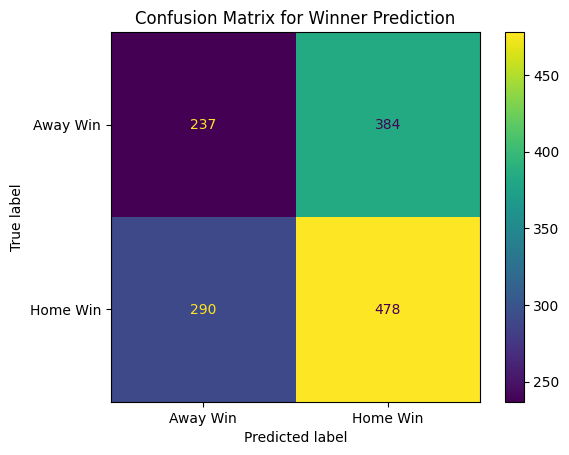

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(test_games['HOME_TEAM_WINS'], test_games['HOME_TEAM_WINS_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Away Win', 'Home Win'])
disp.plot()
plt.title('Confusion Matrix for Winner Prediction')
plt.show()


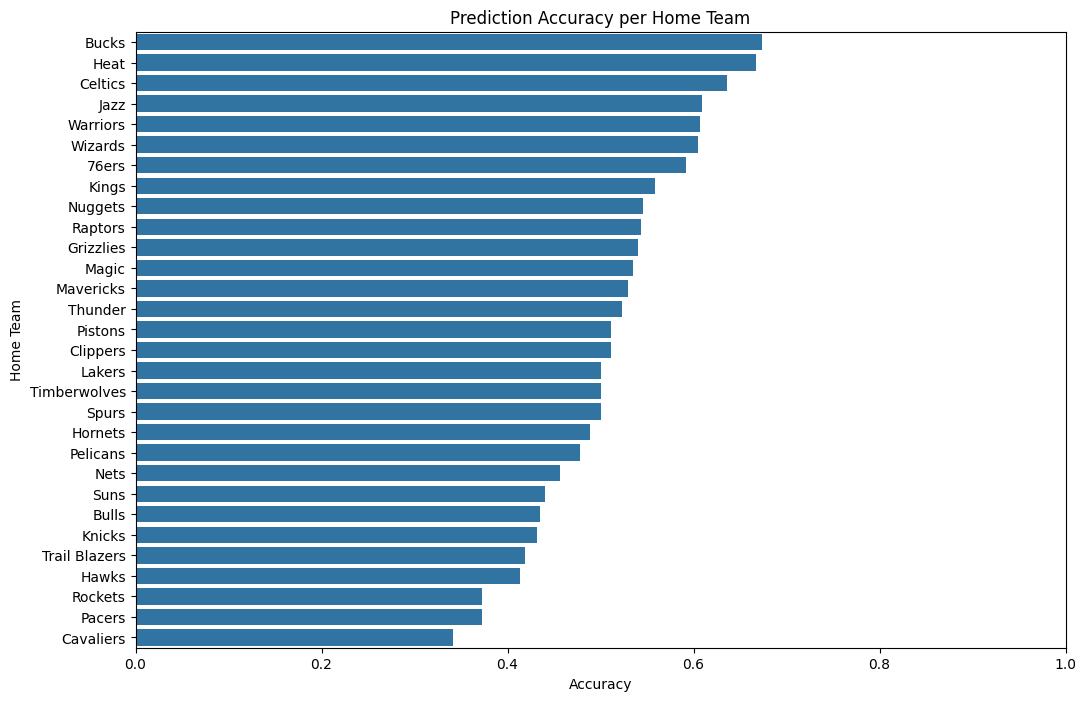

In [17]:
# Group by home team and calculate accuracy
team_accuracy = test_games.groupby('HOME_TEAM_NAME').apply(
    lambda x: accuracy_score(x['HOME_TEAM_WINS'], x['HOME_TEAM_WINS_pred'])
).reset_index(name='Accuracy')

# Sort by accuracy
team_accuracy = team_accuracy.sort_values(by='Accuracy', ascending=False)

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=team_accuracy, x='Accuracy', y='HOME_TEAM_NAME')
plt.title('Prediction Accuracy per Home Team')
plt.xlabel('Accuracy')
plt.ylabel('Home Team')
plt.xlim(0, 1)
plt.show()
